In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from app.wadray import Wad, Ray, _W, _R
from app.utils import *

os.environ["DISABLE_EXTERNAL"] = "T"  # To make it faster

YAML_SETUP = """
module: app.prototype
risk_modules:
  - name: Roulette
    mcr_percentage: 1
    premium_share: 0
    ensuro_share: 0
currency:  
  name: USD
  symbol: $
  initial_supply: 1100000
  initial_balances:
  - user: LP1
    amount: 1000000
  - user: CUST1
    amount: 100000
etokens:
  - name: eUSD1WEEK
    expiration_period: 604800
  - name: eUSD1MONTH
    expiration_period: 2592000
  - name: eUSD1YEAR
    expiration_period: 31536000
"""

# protocol = load_config(StringIO(YAML_SETUP))

In [2]:
def policy_factory(protocol, *args, **kwargs):
    return protocol.new_policy(
        "Roulette", payout=_W(360), premium=_W(10), customer="CUST1",
        loss_prob=_R(1/37), expiration=protocol.now() + int(9.5 * DAY),
    )


def policy_resolver(policy_id, protocol, today, **kwargs):
    policy = protocol.policies.get(policy_id)
    if policy.expiration > today:
        return None
    return random.random() <= (1/37)


class MyObserver(SimulationObserver):
    metrics = ["total_supply", "profit", "mcr", "ocean"]

    def start(self, protocol, **kwargs):
        super().start(protocol=protocol, **kwargs)
        amount = _W(1000000)
        protocol.currency.approve("LP1", protocol.contract_id, amount)
        protocol.currency.approve("CUST1", protocol.contract_id, _W(100000))
        print("LP1 deposits 1M, balance: {}".format(protocol.deposit("eUSD1YEAR", "LP1", amount)))
        self.token = protocol.etokens["eUSD1YEAR"]
        self.initial_supply = self.token.total_supply()

    def get_mcr(self, protocol, **kwargs):
        return self.token.mcr.to_float()

    def get_total_supply(self, protocol, **kwargs):
        return self.token.total_supply().to_float()

    def get_ocean(self, protocol, **kwargs):
        return self.token.ocean.to_float()

    def get_profit(self, protocol, **kwargs):
        return (self.token.total_supply() - self.initial_supply).to_float()



days = 100
    
policy_distribution = list(evenly_distribute(10000, days))

This was the result of the simulation when running direct implementation (premiums and losses directly impact pool)

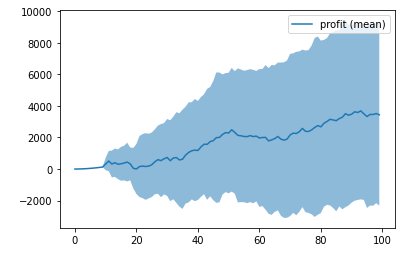

In [3]:
class MySmoothObserver(MyObserver):
    metrics = MyObserver.metrics + ["protocol_loan"]

    def get_protocol_loan(self, protocol, **kwargs):
        return self.token.protocol_loan.to_float()


observer_smooth = MySmoothObserver()

for run in range(50):
    protocol = load_config(StringIO(YAML_SETUP))    
    run_simulation(
        protocol, DAY, policy_distribution,
        policy_factory, policy_resolver, observer_smooth
    )

LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1

/opt/conda/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)
/opt/conda/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)


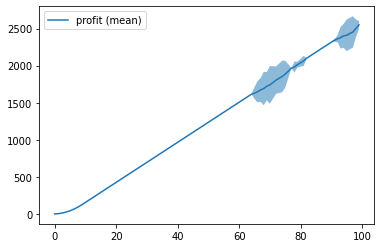

In [4]:
fig, ax = plt.subplots()
profit_mean = observer_smooth.mean("profit")
profit_std = observer_smooth.std("profit")

ax.plot(range(days), profit_mean, '-', label="profit (mean)")
ax.fill_between(range(days), profit_mean - profit_std, profit_mean + profit_std, alpha=0.5)
ax.legend()

In [5]:
observer_smooth_underestimated_loss = MySmoothObserver()

def policy_factory(protocol, *args, **kwargs):
    return protocol.new_policy(
        "Roulette", payout=_W(360), premium=_W(10), customer="CUST1",
        loss_prob=_R(90/3700), expiration=protocol.now() + int(9.5 * DAY),
    )


for run in range(20):
    protocol = load_config(StringIO(YAML_SETUP))    
    run_simulation(
        protocol, DAY, policy_distribution,
        policy_factory, policy_resolver, observer_smooth_underestimated_loss
    )



LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000


/opt/conda/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)
/opt/conda/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)


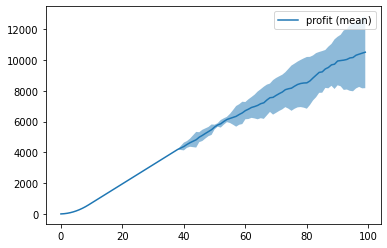

In [6]:
fig, ax = plt.subplots()
profit_mean = observer_smooth_underestimated_loss.mean("profit")
profit_std = observer_smooth_underestimated_loss.std("profit")

ax.plot(range(days), profit_mean, '-', label="profit (mean)")
ax.fill_between(range(days), profit_mean - profit_std, profit_mean + profit_std, alpha=0.5)
ax.legend()

In [8]:
observer_smooth_overestimated_loss = MySmoothObserver()

def policy_factory(protocol, *args, **kwargs):
    return protocol.new_policy(
        "Roulette", payout=_W(360), premium=_W(10), customer="CUST1",
        loss_prob=_R(102/3700), expiration=protocol.now() + int(9.5 * DAY),
    )


for run in range(20):
    protocol = load_config(StringIO(YAML_SETUP))    
    run_simulation(
        protocol, DAY, policy_distribution,
        policy_factory, policy_resolver, observer_smooth_overestimated_loss
    )



LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000
LP1 deposits 1M, balance: 1000000


/opt/conda/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)
/opt/conda/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)


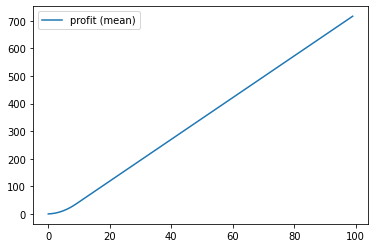

In [9]:
fig, ax = plt.subplots()
profit_mean = observer_smooth_overestimated_loss.mean("profit")
profit_std = observer_smooth_overestimated_loss.std("profit")

ax.plot(range(days), profit_mean, '-', label="profit (mean)")
ax.fill_between(range(days), profit_mean - profit_std, profit_mean + profit_std, alpha=0.5)
ax.legend()